In [1]:
import pymc as pm
import arviz as az

from scipy.stats import beta, gamma
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from scipy.optimize import minimize

## 5.1 Pearson correlation

Pearson相关系数
- $r\in [-1, 1]$, 代表两个变量相关性，符号反应方向，绝对值反应强度
- 相比于点估计，置信区间可能是更有参考性的

多元高斯分布（会写矩阵但是太麻烦了）
$$(x_1, x_2)\sim \mathcal{N}((\mu_1, \mu_2)^T, \Sigma), \Sigma = [\sigma_1^2, \rho\sigma_1\sigma_2; \rho\sigma_1\sigma_2, \sigma_2^2]$$

In [25]:
x_obs = np.array([[0.3, 0.5, 0.6, 0.7, 0.75, 0.9, 1, 1.1, 1.25, 1.3, 1.4], 
                 [110, 100, 113, 103, 102, 105, 98, 89, 99, 93, 87]]).T
with pm.Model() as PearsonCorralation:
    rho = pm.Uniform('rho', lower = -1, upper = 1)
    mu = pm.Normal('mu', mu = 0, tau = 0.001, shape = 2)
    lamb = pm.Gamma('lamb', alpha = 0.001, beta = 0.001, shape = 2)
    sigma = pm.Deterministic('sigma', lamb**(-0.5))
    cov_matrix = pm.math.stack([[sigma[0]**2, rho * sigma[0] * sigma[1]],
                                [rho * sigma[0] * sigma[1], sigma[1]**2]])
    x = pm.MvNormal("x", mu = mu, cov = cov_matrix, observed = x_obs)
    trace = pm.sample(2000)
pm.model_to_graphviz(PearsonCorralation)
az.summary(trace, var_names = 'rho')


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rho,-0.682,0.173,-0.937,-0.36,0.003,0.003,3273.0,3258.0,1.0


In [22]:
# Exercise 5.1.1
## 重复生成双倍的数据，就是更少的变异性
x_longer = np.concatenate([x_obs, x_obs])
with pm.Model() as PearsonCorralation:
    rho = pm.Uniform('rho', lower = -1, upper = 1)
    mu = pm.Normal('mu', mu = 0, tau = 0.001, shape = 2)
    lamb = pm.Gamma('lamb', alpha = 0.001, beta = 0.001, shape = 2)
    sigma = pm.Deterministic('sigma', lamb**(-0.5))
    cov_matrix = pm.math.stack([[sigma[0]**2, rho * sigma[0] * sigma[1]],
                                [rho * sigma[0] * sigma[1], sigma[1]**2]])
    x = pm.MvNormal("x", mu = mu, cov = cov_matrix, observed = x_longer)
    trace = pm.sample(2000)
az.summary(trace, var_names = 'rho')

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, mu, lamb]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 43 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rho,-0.747,0.099,-0.909,-0.562,0.002,0.001,3999.0,4182.0,1.0


In [30]:
# Exercise 5.1.2
## 更符合数据真实情况的prior（原来的prior太草率了啊），其实影响不大
## 不过我觉得：更一般的做法是先把数据scale一下子，再去分析
x_longer = np.concatenate([x_obs, x_obs])
with pm.Model() as PearsonCorralation:
    rho = pm.Uniform('rho', lower = -1, upper = 1)
    mu1 = pm.Uniform('mu1', lower = 0.1, upper = 1.9)
    mu2 = pm.Normal('mu2', mu = 100, sigma = 15)
    lamb = pm.Gamma('lamb', alpha = 0.001, beta = 0.001, shape = 2)
    sigma = pm.Deterministic('sigma', lamb**(-0.5))
    cov_matrix = pm.math.stack([[sigma[0]**2, rho * sigma[0] * sigma[1]],
                                [rho * sigma[0] * sigma[1], sigma[1]**2]])
    x = pm.MvNormal("x", mu = pm.math.stack([mu1, mu2]), cov = cov_matrix, observed = x_longer)
    trace = pm.sample(2000)
az.summary(trace, var_names = 'rho')

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, mu1, mu2, lamb]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 43 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rho,-0.749,0.099,-0.912,-0.569,0.002,0.002,4163.0,4459.0,1.0


## 5.2 Pearson Correlation with uncertainty

这里我们假设观测值，都是真实值加上高斯噪声的结果

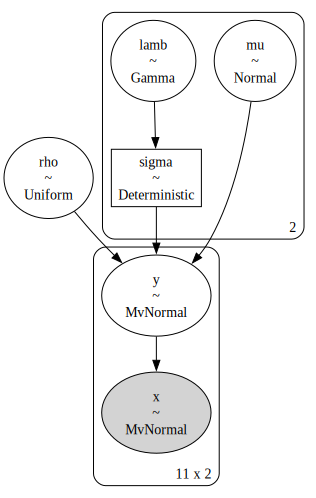

In [35]:
with pm.Model() as PearsonCorralationUncertainty:
    sigma_err = np.array([0.03, 1])
    rho = pm.Uniform('rho', lower = -1, upper = 1)
    mu = pm.Normal('mu', mu = 0, tau = 0.001, shape = 2)
    lamb = pm.Gamma('lamb', alpha = 0.001, beta = 0.001, shape = 2)
    sigma = pm.Deterministic('sigma', lamb**(-0.5))
    cov_matrix = pm.math.stack([[sigma[0]**2, rho * sigma[0] * sigma[1]],
                                [rho * sigma[0] * sigma[1], sigma[1]**2]])
    y = pm.MvNormal("y", mu = mu, cov = cov_matrix, shape = (11, 2))
    x = pm.MvNormal("x", mu = y, cov = pm.math.stack([[sigma_err[0]**2, 0], [0, sigma_err[1]**2]]), observed = x_obs)
pm.model_to_graphviz(PearsonCorralationUncertainty)

In [36]:
# Exercise 5.2.1
## 当容许误差后，似乎整个相关系数绝对值更大了，允许更强的相关出现？
with PearsonCorralationUncertainty:
    trace = pm.sample(2000)
az.summary(trace, var_names = 'rho')

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, mu, lamb, y]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 58 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rho,-0.688,0.172,-0.942,-0.36,0.002,0.002,5462.0,4428.0,1.0


In [39]:
# 这里我们check一个东西！直接把噪声加在矩阵上，是完全等价的
with pm.Model() as PearsonCorralationUncertainty:
    sigma_err = np.array([0.03, 1])
    rho = pm.Uniform('rho', lower = -1, upper = 1)
    mu = pm.Normal('mu', mu = 0, tau = 0.001, shape = 2)
    lamb = pm.Gamma('lamb', alpha = 0.001, beta = 0.001, shape = 2)
    sigma = pm.Deterministic('sigma', lamb**(-0.5))
    cov_matrix = pm.math.stack([[sigma[0]**2 + sigma_err[0]**2, rho * sigma[0] * sigma[1]],
                                [rho * sigma[0] * sigma[1], sigma[1]**2 + sigma_err[1]**2]])
    x = pm.MvNormal("x", mu = mu, cov = cov_matrix, observed=x_obs)
    trace = pm.sample(2000)
pm.model_to_graphviz(PearsonCorralationUncertainty)
az.summary(trace, var_names = 'rho')

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, mu, lamb]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 57 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rho,-0.689,0.175,-0.943,-0.363,0.003,0.003,3971.0,3505.0,1.0


In [40]:
# Exercise 5.2.2
## 如果容许更大的方差呢？就找不到任何证据了
with pm.Model() as PearsonCorralationUncertainty:
    sigma_err = np.array([0.03, 10])
    rho = pm.Uniform('rho', lower = -1, upper = 1)
    mu = pm.Normal('mu', mu = 0, tau = 0.001, shape = 2)
    lamb = pm.Gamma('lamb', alpha = 0.001, beta = 0.001, shape = 2)
    sigma = pm.Deterministic('sigma', lamb**(-0.5))
    cov_matrix = pm.math.stack([[sigma[0]**2 + sigma_err[0]**2, rho * sigma[0] * sigma[1]],
                                [rho * sigma[0] * sigma[1], sigma[1]**2 + sigma_err[1]**2]])
    x = pm.MvNormal("x", mu = mu, cov = cov_matrix, observed=x_obs)
    trace = pm.sample(2000)
pm.model_to_graphviz(PearsonCorralationUncertainty)
az.summary(trace, var_names = 'rho')

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, mu, lamb]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 50 seconds.
There were 387 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rho,-0.272,0.567,-1.0,0.772,0.008,0.005,3976.0,2879.0,1.0


In [43]:
# Exercise 5.2.3
## 拓展到方差未知的情况
with pm.Model() as PearsonCorralationUncertainty:
    sigma_err = pm.Gamma('sigma_err', alpha = 0.001, beta = 0.001, shape = 2)
    rho = pm.Uniform('rho', lower = -1, upper = 1)
    mu = pm.Normal('mu', mu = 0, tau = 0.001, shape = 2)
    lamb = pm.Gamma('lamb', alpha = 0.001, beta = 0.001, shape = 2)
    sigma = pm.Deterministic('sigma', lamb**(-0.5))
    cov_matrix = pm.math.stack([[sigma[0]**2 + sigma_err[0]**(-1), rho * sigma[0] * sigma[1]],
                                [rho * sigma[0] * sigma[1], sigma[1]**2 + sigma_err[1]**(-1)]])
    x = pm.MvNormal("x", mu = mu, cov = cov_matrix, observed=x_obs)
    trace = pm.sample(2000)
pm.model_to_graphviz(PearsonCorralationUncertainty)
az.summary(trace, var_names = ['rho', 'sigma_err'])

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_err, rho, mu, lamb]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 45 seconds.
There were 125 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rho,-0.722,0.249,-1.000,-0.318,0.006,0.012,1685.0,1539.0,1.0
sigma_err[0],212.651,400.803,1.675,874.695,6.665,13.137,2255.0,2711.0,1.0
sigma_err[1],94.045,286.410,0.001,454.815,3.663,12.574,1008.0,571.0,1.0


## 5.3 the Kappa Coefficient of Agreement

一个决策（代价更低）和“金标准”（代价更高）的一致程度
- a: hit; b: miss; c: false alarm(FA); d:correct reject(CR)
- 选择一致的比率：$p_o = (a+d)/n$
- 偶然一致的比率：$p_e = [(a+b)(a+c) + (b+d)(c+d)]/n^2$
- 矫正后的一致程度：$\kappa = (p_o - p_e)/(1-p_e)$


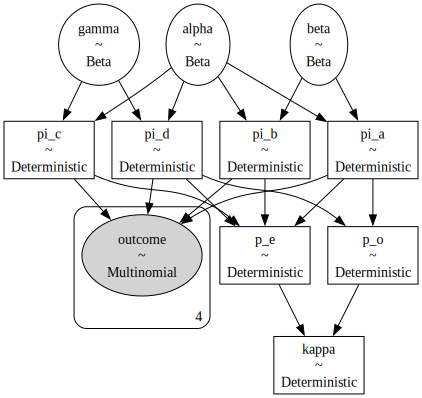

In [47]:
with pm.Model() as KappaCoefficient:
    n, obs = 233, np.array([14, 4, 5, 210])
    alpha = pm.Beta('alpha', alpha = 1, beta = 1) # Actual 1
    beta = pm.Beta('beta', alpha = 1, beta = 1) # Hit p(1|1)
    gamma = pm.Beta('gamma', alpha = 1, beta = 1) # CR p(0|0)
    pi_a = pm.Deterministic('pi_a', alpha * beta)
    pi_b = pm.Deterministic('pi_b', alpha * (1 - beta))
    pi_c = pm.Deterministic('pi_c', (1 - alpha) * (1 - gamma))
    pi_d = pm.Deterministic('pi_d', (1 - alpha) * gamma)
    xi = pm.Deterministic('p_o', pi_a + pi_d)
    phi = pm.Deterministic('p_e', (pi_a + pi_b)*(pi_a+pi_c) + (pi_b+pi_d)*(pi_c+pi_d))
    kappa = pm.Deterministic('kappa', (xi - phi)/(1-phi))
    y = pm.Multinomial("outcome", n = n, p = pm.math.stack([pi_a, pi_b, pi_c, pi_d]), observed = obs)
pm.model_to_graphviz(KappaCoefficient)

In [48]:
# Exercise 5.3.1
## Miss概率为0.251，FA概率为0.028，Miss的概率比较高
## 替代方案和金标准之间的一致性是“fair to good”，尽管诊断一致率高达95.4%
with KappaCoefficient:
    trace = pm.sample(2000)
pm.summary(trace)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, gamma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 23 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.081,0.018,0.050,0.116,0.000,0.000,10032.0,6201.0,1.0
beta,0.749,0.092,0.584,0.918,0.001,0.001,10812.0,5621.0,1.0
gamma,0.972,0.011,0.952,0.990,0.000,0.000,11100.0,6362.0,1.0
pi_a,0.061,0.015,0.034,0.090,0.000,0.000,9491.0,6244.0,1.0
pi_b,0.020,0.009,0.006,0.037,0.000,0.000,10274.0,6170.0,1.0
pi_c,0.025,0.010,0.009,0.044,0.000,0.000,11068.0,6355.0,1.0
pi_d,0.894,0.020,0.856,0.930,0.000,0.000,10840.0,6465.0,1.0
p_o,0.954,0.013,0.930,0.978,0.000,0.000,11101.0,6489.0,1.0
p_e,0.847,0.027,0.797,0.900,0.000,0.000,10212.0,6141.0,1.0
kappa,0.697,0.081,0.544,0.847,0.001,0.001,9922.0,5807.0,1.0


p(excellent) = 0.273
p(fair to good) = 0.727


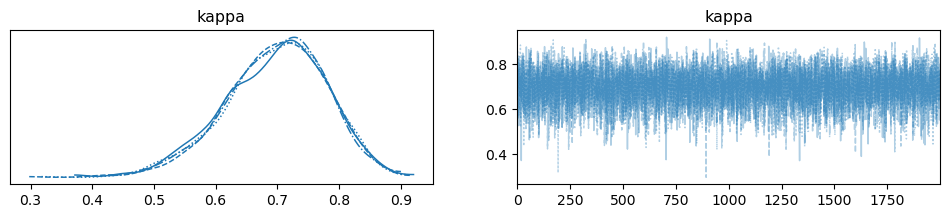

In [57]:
# 进一步从后验分布结合kappa的判别标准
az.plot_trace(trace, var_names = 'kappa')
print(f'p(excellent) = {(trace.posterior['kappa'].values > 0.75).mean():.3f}') 
print(f'p(fair to good) = {(abs(trace.posterior['kappa'].values - 0.575) < 0.175).mean():.3f}') 

In [58]:
# 5.3.2 另一组数据，这个一致性居然是poor
with pm.Model() as KappaCoefficient:
    n, obs = 547, np.array([20, 7, 103, 417])
    alpha = pm.Beta('alpha', alpha = 1, beta = 1) # Actual 1
    beta = pm.Beta('beta', alpha = 1, beta = 1) # Hit p(1|1)
    gamma = pm.Beta('gamma', alpha = 1, beta = 1) # CR p(0|0)
    pi_a = pm.Deterministic('pi_a', alpha * beta)
    pi_b = pm.Deterministic('pi_b', alpha * (1 - beta))
    pi_c = pm.Deterministic('pi_c', (1 - alpha) * (1 - gamma))
    pi_d = pm.Deterministic('pi_d', (1 - alpha) * gamma)
    xi = pm.Deterministic('p_o', pi_a + pi_d)
    phi = pm.Deterministic('p_e', (pi_a + pi_b)*(pi_a+pi_c) + (pi_b+pi_d)*(pi_c+pi_d))
    kappa = pm.Deterministic('kappa', (xi - phi)/(1-phi))
    y = pm.Multinomial("outcome", n = n, p = pm.math.stack([pi_a, pi_b, pi_c, pi_d]), observed = obs)
    trace = pm.sample(2000)
pm.summary(trace)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, gamma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 23 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.051,0.009,0.034,0.069,0.000,0.000,12276.0,6088.0,1.0
beta,0.723,0.083,0.570,0.878,0.001,0.001,11729.0,6460.0,1.0
gamma,0.801,0.017,0.768,0.832,0.000,0.000,11789.0,6418.0,1.0
pi_a,0.037,0.008,0.022,0.052,0.000,0.000,11655.0,5823.0,1.0
pi_b,0.014,0.005,0.005,0.023,0.000,0.000,11976.0,6230.0,1.0
pi_c,0.189,0.017,0.159,0.220,0.000,0.000,11862.0,6437.0,1.0
pi_d,0.760,0.018,0.727,0.794,0.000,0.000,11741.0,6731.0,1.0
p_o,0.797,0.017,0.765,0.829,0.000,0.000,12130.0,6364.0,1.0
p_e,0.746,0.018,0.712,0.778,0.000,0.000,11381.0,6664.0,1.0
kappa,0.199,0.044,0.123,0.285,0.000,0.000,11255.0,6480.0,1.0


p(excellent) = 0.000
p(fair to good) = 0.000
p(poor)) = 1.000


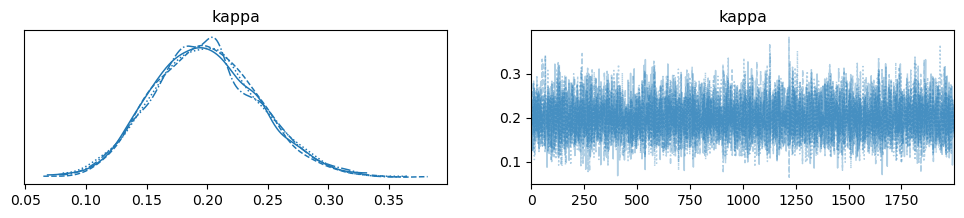

In [61]:
# 进一步从后验分布结合kappa的判别标准
az.plot_trace(trace, var_names = 'kappa')
print(f'p(excellent) = {(trace.posterior['kappa'].values > 0.75).mean():.3f}') 
print(f'p(fair to good) = {(abs(trace.posterior['kappa'].values - 0.575) < 0.175).mean():.3f}') 
print(f'p(poor)) = {(trace.posterior['kappa'].values < 0.4).mean():.3f}') 

In [63]:
# 5.3.3 另一组数据，这个一致性同样很poor
with pm.Model() as KappaCoefficient:
    n, obs = 170, np.array([0, 0, 13, 157])
    alpha = pm.Beta('alpha', alpha = 1, beta = 1) # Actual 1
    beta = pm.Beta('beta', alpha = 1, beta = 1) # Hit p(1|1)
    gamma = pm.Beta('gamma', alpha = 1, beta = 1) # CR p(0|0)
    pi_a = pm.Deterministic('pi_a', alpha * beta)
    pi_b = pm.Deterministic('pi_b', alpha * (1 - beta))
    pi_c = pm.Deterministic('pi_c', (1 - alpha) * (1 - gamma))
    pi_d = pm.Deterministic('pi_d', (1 - alpha) * gamma)
    xi = pm.Deterministic('p_o', pi_a + pi_d)
    phi = pm.Deterministic('p_e', (pi_a + pi_b)*(pi_a+pi_c) + (pi_b+pi_d)*(pi_c+pi_d))
    kappa = pm.Deterministic('kappa', (xi - phi)/(1-phi))
    y = pm.Multinomial("outcome", n = n, p = pm.math.stack([pi_a, pi_b, pi_c, pi_d]), observed = obs)
    trace = pm.sample(2000)
pm.summary(trace)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, gamma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 22 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.006,0.006,0.000,0.016,0.000,0.000,5855.0,3620.0,1.0
beta,0.497,0.293,0.001,0.945,0.004,0.002,5717.0,4544.0,1.0
gamma,0.918,0.021,0.879,0.956,0.000,0.000,5811.0,4881.0,1.0
pi_a,0.003,0.004,0.000,0.010,0.000,0.000,5393.0,4109.0,1.0
pi_b,0.003,0.004,0.000,0.010,0.000,0.000,5657.0,3751.0,1.0
pi_c,0.081,0.021,0.043,0.119,0.000,0.000,5804.0,5000.0,1.0
pi_d,0.913,0.021,0.873,0.953,0.000,0.000,6080.0,4797.0,1.0
p_o,0.916,0.021,0.878,0.955,0.000,0.000,5941.0,5306.0,1.0
p_e,0.911,0.022,0.871,0.952,0.000,0.000,6186.0,4951.0,1.0
kappa,0.053,0.066,-0.015,0.182,0.001,0.001,5724.0,5266.0,1.0


p(excellent) = 0.000
p(fair to good) = 0.001
p(poor)) = 0.999


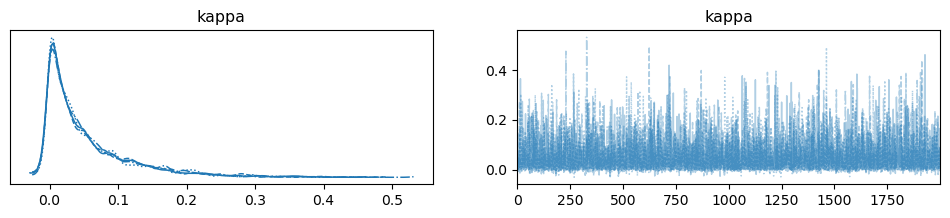

In [64]:
# 进一步从后验分布结合kappa的判别标准
az.plot_trace(trace, var_names = 'kappa')
print(f'p(excellent) = {(trace.posterior['kappa'].values > 0.75).mean():.3f}') 
print(f'p(fair to good) = {(abs(trace.posterior['kappa'].values - 0.575) < 0.175).mean():.3f}') 
print(f'p(poor)) = {(trace.posterior['kappa'].values < 0.4).mean():.3f}') 

## 5.4 Change Detection in time series data

假定数据来自方差相同，但是均值发生了骤变的数据

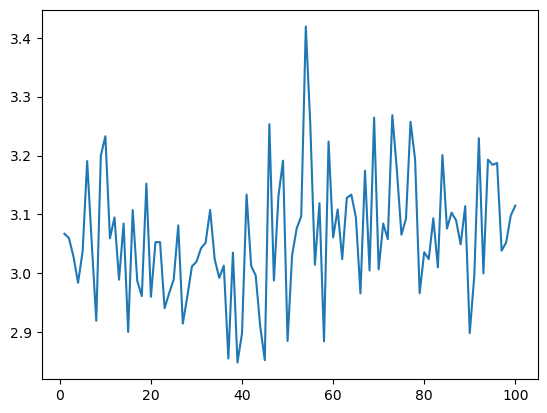

In [77]:
t = np.arange(1, 101)
mu = np.array([3] * 50 + [3.1] * 50)
c_obs = np.random.normal(loc = mu, scale = 0.1)
plt.plot(t, c_obs)


In [ ]:
with pm.Model() as ChangeDetection:
    mus = pm.Normal('mus', mu = 0, tau = 0.001, shape = 2)
    lamb = pm.Gamma('lamb', alpha = 0.001, beta = 0.001)
    tau = pm.DiscreteUniform('tau', lower = 0, upper = len(t))
    mu = pm.math.switch(t < tau, mus[0], mus[1])
    c = pm.Normal('c', mu = mu, tau = lamb, observed = c_obs)
pm.model_to_graphviz(ChangeDetection)

In [76]:
with ChangeDetection:
    trace = pm.sample(2000)
az.summary(trace)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mus, lamb]
>Metropolis: [tau]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mus[0],3.010,0.016,2.980,3.040,0.000,0.000,2068.0,1310.0,1.00
mus[1],3.097,0.016,3.068,3.127,0.000,0.000,6995.0,5295.0,1.00
tau,52.554,5.621,43.000,62.000,0.351,0.787,564.0,320.0,1.01
lamb,92.047,13.649,67.974,118.630,0.178,0.156,5839.0,5479.0,1.00


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,52.554,5.621,43.0,62.0,0.351,0.787,564.0,320.0,1.01


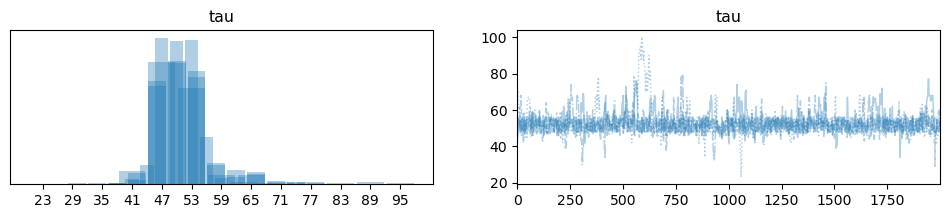

In [94]:
# 5.4.1 
## 还是很惊讶pymc可以这么精确的找到转折点的
az.plot_trace(trace, var_names = 'tau')
az.summary(trace, var_names = 'tau')

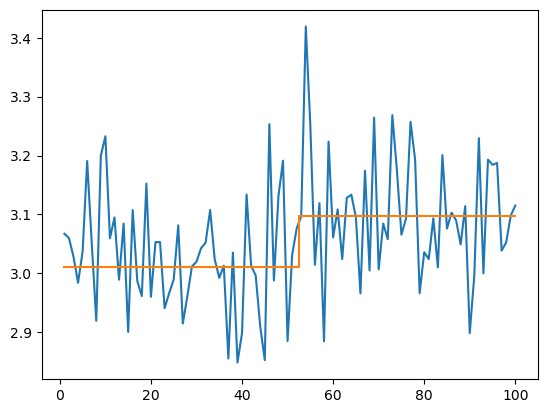

In [93]:
# Exercise 5.4.2
## 问题没有很理解，有没有可能这个图是误导性的（可能是渐变而不是骤变？）
mu1 = az.summary(trace)['mean'].values[0]
mu2 = az.summary(trace)['mean'].values[1]
tau = az.summary(trace)['mean'].values[2]
plt.plot(t, c_obs)
plt.plot([1, tau, tau, len(t)], [mu1, mu1, mu2, mu2])

## 5.5 Censored Data

Cha Sa-soon: 68岁老人考驾照
- 50道4选1题目，答对至少30道题可以通过
- 前949次都失败，第950次成功
- 假设所有题目同样困难，且Cha Sa-soon不会有任何提高

设限制（censored）数据
- 不知道具体的值，但是知道一些信息，也叫部分观察
- 比如前面的测验，前面都是15-25道


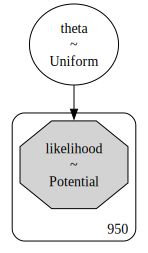

In [112]:
n_question = 50
y = np.array([1] * 949 + [0])
# 一个实现思路是，直接用暴力输出累计概率代替截断二项分布
with pm.Model() as ChaSasoon:
    theta = pm.Uniform('theta', lower = 0.25, upper = 1)
    z_low = pm.math.switch(pm.math.eq(y, 1), 15, 30)
    z_high = pm.math.switch(pm.math.eq(y, 1), 25, 30)
    cdf_low = pm.Binomial.logcdf(z_low - 1, n = n_question, p = theta)
    cdf_high = pm.Binomial.logcdf(z_high, n = n_question, p = theta)
    trunc_prob = pm.math.exp(cdf_high) - pm.math.exp(cdf_low)
    prob = pm.math.switch(pm.math.eq(y, 1), trunc_prob, 1)
    likelihood = pm.Potential('likelihood', pm.math.log(prob))
pm.model_to_graphviz(ChaSasoon)


In [111]:
# 一个实现思路是，定义二项分布类，但是这个例子中用不到了
class TruncatedBinomial(pm.Discrete):
    def __init__(self, n, p, z_low, z_high):
        self.n, self.p, self.z_low, self.z_high = n, p, z_low, z_high
    
    def logp(self, value):
        idx = pm.math.and_(pm.math.ge(value, self.z_low), pm.math.le(value, self.z_high))
        logp = pm.Binomial.logp(value, self.n, self.p)
        log_prob_low = pm.Binomial.logcdf(self.z_low - 1, self.n, self.p)
        log_prob_high = pm.Binomial.logcdf(self.z_high, self.n, self.p)
        trunc_norm = pm.math.log(pm.math.exp(log_prob_high) - pm.math.exp(log_prob_low))
        return pm.math.switch(idx, logp - trunc_norm, -pm.math.inf)

In [113]:
# Exercise 5.5.1
## 94%HDI是[0.392, 0.405]，高于随机水平，但是远不足及格水平
with ChaSasoon:
    trace = pm.sample(2000)
az.summary(trace)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 34 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.398,0.004,0.392,0.405,0.0,0.0,3744.0,5424.0,1.0


In [115]:
# Exercise 5.5.2
## 如果这个假设是0-29（只知道没有通过呢），theta是进一步变小的，大概到0.3
## sample的结果 94%HDI 为 [0.25, 0.372]
n_question = 50
y = np.array([1] * 949 + [0])
# 一个实现思路是，直接用暴力输出累计概率代替截断二项分布
with pm.Model() as ChaSasoon:
    theta = pm.Uniform('theta', lower = 0.25, upper = 1)
    z_low = pm.math.switch(pm.math.eq(y, 1), 0, 30)
    z_high = pm.math.switch(pm.math.eq(y, 1), 29, 30)
    cdf_low = pm.Binomial.logcdf(z_low - 1, n = n_question, p = theta)
    cdf_high = pm.Binomial.logcdf(z_high, n = n_question, p = theta)
    trunc_prob = pm.math.exp(cdf_high) - pm.math.exp(cdf_low)
    prob = pm.math.switch(pm.math.eq(y, 1), trunc_prob, 1)
    likelihood = pm.Potential('likelihood', pm.math.log(prob))
    trace = pm.sample(2000)
az.summary(trace)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 45 seconds.
There were 175 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.312,0.036,0.25,0.372,0.001,0.0,1309.0,1211.0,1.0


In [128]:
# Exercise 5.5.3
## 如果不改变最后一次的得分，无论失败多少次都没有区别
with pm.Model() as ChaSasoon:
    n_question = 50
    y = np.array([1] * 1 + [0])
    theta = pm.Uniform('theta', lower = 0.25, upper = 1)
    z_low = pm.math.switch(pm.math.eq(y, 1), 0, 30)
    z_high = pm.math.switch(pm.math.eq(y, 1), 29, 30)
    cdf_low = pm.Binomial.logcdf(z_low - 1, n = n_question, p = theta)
    cdf_high = pm.Binomial.logcdf(z_high, n = n_question, p = theta)
    trunc_prob = pm.math.exp(cdf_high) - pm.math.exp(cdf_low)
    prob = pm.math.switch(pm.math.eq(y, 1), trunc_prob, 1)
    likelihood = pm.Potential('likelihood', pm.math.log(prob))
    trace = pm.sample(2000)
az.summary(trace)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 21 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.424,0.107,0.251,0.599,0.002,0.001,1893.0,2033.0,1.0


In [131]:
# Exercise 5.5.4
## 最最一无所知的情形
with pm.Model() as ChaSasoon:
    n_question = 50
    y = np.array([1] * 9 + [0])
    theta = pm.Uniform('theta', lower = 0.25, upper = 1)
    z_low = pm.math.switch(pm.math.eq(y, 1), 0, 30)
    z_high = pm.math.switch(pm.math.eq(y, 1), 29, 50)
    cdf_low = pm.Binomial.logcdf(z_low - 1, n = n_question, p = theta)
    cdf_high = pm.Binomial.logcdf(z_high, n = n_question, p = theta)
    trunc_prob = pm.math.exp(cdf_high) - pm.math.exp(cdf_low)
    prob = pm.math.switch(pm.math.eq(y, 1), trunc_prob, 1)
    likelihood = pm.Potential('likelihood', pm.math.log(prob))
    obs_test = pm.Binomial('test', n_question, theta)
    trace = pm.sample(2000)
az.summary(trace)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [theta]
>Metropolis: [test]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 25 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
test,18.947,5.021,9.000,27.000,0.198,0.088,652.0,1256.0,1.0
theta,0.378,0.073,0.251,0.494,0.003,0.001,672.0,1190.0,1.0


In [133]:
with ChaSasoon:
    post_prod = pm.sample_posterior_predictive(trace, var_names = ['test'])

/var/folders/ng/wvk09yds4gv2y8y9_scjr5mc0000gn/T/ipykernel_81989/2818498359.py:2: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  post_prod = pm.sample_posterior_predictive(trace, var_names = ['test'])
Sampling: [test]


Output()

<Axes: >

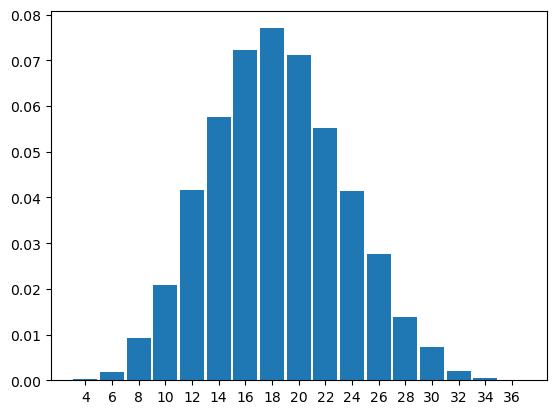

In [139]:
az.plot_dist(post_prod.posterior_predictive['test'])


## 5.6 Recapturing planes

标志重捕法：总体t中捕捉一部分样本x，标记后放生，之后再捕捉一批样本n，观察标记样本占比推断总体K
- 观测到$p(K = k) \sim HyperGeometric(n, x, t) =  \frac{C_x^k C_{n-x}^{n-k}}{C_t^n}$
- 早年不能直接定义超几何分布（在pymc中不成问题），且不能直接定义Potential，用0-1trick间接定义


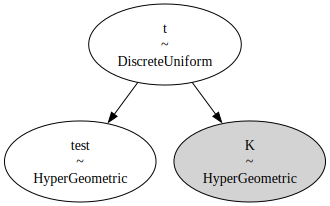

In [155]:
with pm.Model() as RecapturingPlanes:
    x, k_obs, n = 10, 4, 5
    t = pm.DiscreteUniform('t', lower = x + n - k_obs, upper = 50)
    test = pm.HyperGeometric('test', N = t, k = x, n = n)
    K = pm.HyperGeometric('K', N = t, k = x, n = n, observed = k_obs)

pm.model_to_graphviz(RecapturingPlanes)

In [156]:
with RecapturingPlanes:
    trace = pm.sample(2000)
    post_pred = pm.sample_posterior_predictive(trace)
az.summary(trace)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [t]
>Metropolis: [test]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 20 seconds.
Sampling: [K]


Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t,16.721,6.154,11.0,29.0,0.279,0.272,433.0,524.0,1.01
test,3.316,1.236,1.0,5.0,0.056,0.023,494.0,970.0,1.01


array([[<Axes: title={'center': 't'}>, <Axes: title={'center': 't'}>],
       [<Axes: title={'center': 'test'}>,
        <Axes: title={'center': 'test'}>]], dtype=object)

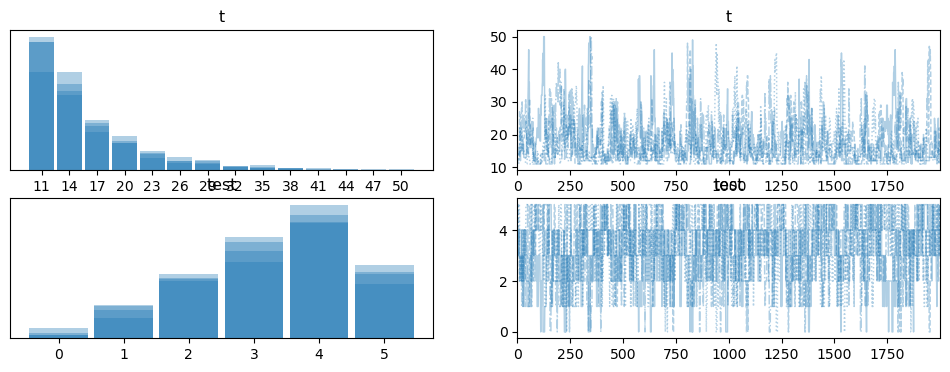

In [158]:
az.plot_trace(trace)

In [159]:
# Exercise 5.6.1
## 如果k改成0
with pm.Model() as RecapturingPlanes:
    x, k_obs, n = 10, 0, 5
    t = pm.DiscreteUniform('t', lower = x + n - k_obs, upper = 50)
    test = pm.HyperGeometric('test', N = t, k = x, n = n)
    K = pm.HyperGeometric('K', N = t, k = x, n = n, observed = k_obs)
    trace = pm.sample(2000)
az.summary(trace)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [t]
>Metropolis: [test]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 23 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t,40.050,7.563,26.0,50.0,0.214,0.119,1221.0,1701.0,1.01
test,1.283,0.956,0.0,3.0,0.024,0.018,1557.0,1540.0,1.00


array([[<Axes: title={'center': 't'}>, <Axes: title={'center': 't'}>],
       [<Axes: title={'center': 'test'}>,
        <Axes: title={'center': 'test'}>]], dtype=object)

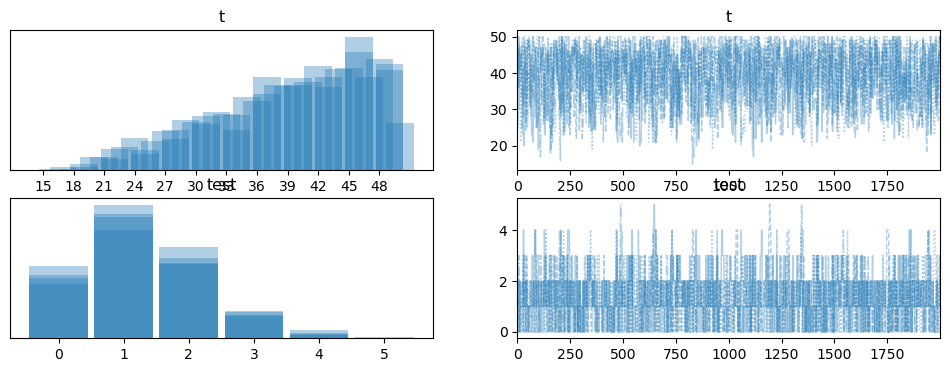

In [160]:
az.plot_trace(trace)

In [161]:
# Exercise 5.6.2
## 如果k改成0，同时增大t上限
with pm.Model() as RecapturingPlanes:
    x, k_obs, n = 10, 0, 5
    t = pm.DiscreteUniform('t', lower = x + n - k_obs, upper = 100)
    test = pm.HyperGeometric('test', N = t, k = x, n = n)
    K = pm.HyperGeometric('K', N = t, k = x, n = n, observed = k_obs)
    trace = pm.sample(2000)
az.summary(trace)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [t]
>Metropolis: [test]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 24 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t,69.862,19.301,36.0,100.0,0.550,0.275,1226.0,1520.0,1.0
test,0.797,0.811,0.0,2.0,0.024,0.015,1150.0,1438.0,1.0


array([[<Axes: title={'center': 't'}>, <Axes: title={'center': 't'}>],
       [<Axes: title={'center': 'test'}>,
        <Axes: title={'center': 'test'}>]], dtype=object)

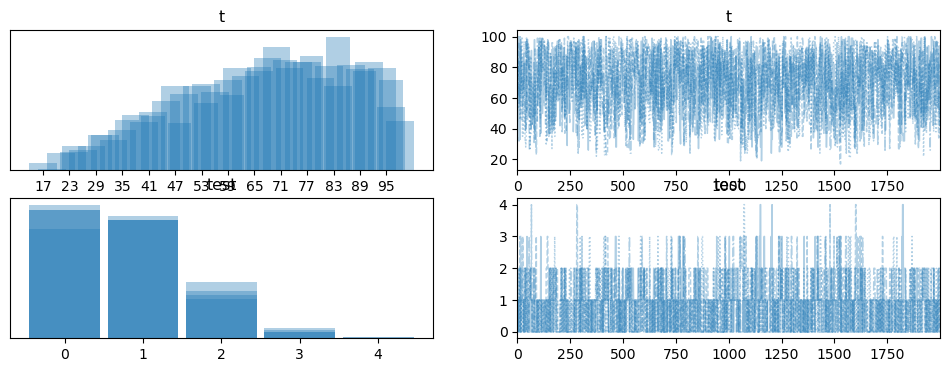

In [162]:
az.plot_trace(trace)